In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14350918918488853536, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1631830780156864304
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17839231073814569509
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15864515789
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14281169466087695388
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [2]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

"""
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))
          
model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])     
"""

#dropout unet
def unet(input_size = (512,512,3)): 
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    outputs = Reshape((512,512))(outputs)
    
    model = Model(input = inputs, output = outputs)
    
    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)
    
    return model


#batch norm unet
def unetbn(input_size = (512,512,3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    #c1 = Dropout(0.1) (c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (p1)
    #c2 = Dropout(0.1) (c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (p2)
    #c3 = Dropout(0.2) (c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    #c4 = Dropout(0.2) (c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    #c5 = Dropout(0.3) (c5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u6)
    #c6 = Dropout(0.2) (c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (u7)
    #c7 = Dropout(0.2) (c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (u8)
    #c8 = Dropout(0.1) (c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
    #c9 = Dropout(0.1) (c9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    outputs = Reshape((512,512))(outputs)
    
    model = Model(input = inputs, output = outputs)
    
    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)
    
    return model

#fcn8-vgg16
def FCN8( nClasses = 2 ,  input_height=512, input_width=512):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller

    IMAGE_ORDERING =  "channels_last" 
    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #use vgg?   
    vgg  = Model(img_input , pool5)
    vgg.load_weights('vgg.h5') ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose(1, kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('sigmoid'))(o)
    o = Reshape((512,512))(o)
    
    model = Model(img_input, o)
    
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)

    return model



Using TensorFlow backend.


In [26]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])

print (len(train_img_paths))
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/10729_sat.jpg', 'train/51187_sat.jpg', 'train/52299_sat.jpg', 'train/4962_sat.jpg', 'train/13549_sat.jpg', 'train/15363_sat.jpg', 'train/38456_sat.jpg', 'train/50517_sat.jpg', 'train/32252_sat.jpg', 'train/12993_sat.jpg']
['train/12895_msk.png', 'train/23379_msk.png', 'train/19799_msk.png', 'train/2575_msk.png', 'train/50807_msk.png', 'train/41694_msk.png', 'train/9457_msk.png', 'train/34365_msk.png', 'train/47347_msk.png', 'train/21599_msk.png']
10897
['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']


In [4]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id


def get_img_id2(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_pred')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask
        
def image_gen2(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id2(img_path)
        mask_path = os.path.join(path_to_pred, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask



In [5]:
#compute average image

average = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
avg = average/10897

In [6]:
#compute standard deviation image

sd = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, avg)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/10897
sd = np.sqrt(sd)


In [8]:
print (sd)

[[[ 39.1200441   30.72192687  29.61285695]
  [ 38.77868638  30.33976039  29.19856832]
  [ 39.10822417  30.80489507  29.6288618 ]
  ..., 
  [ 39.18583978  30.78194769  29.5837315 ]
  [ 39.13618024  30.66168139  29.45792469]
  [ 39.32401502  30.83386402  29.66313514]]

 [[ 38.82741266  30.52046149  29.35707065]
  [ 38.56653406  30.27412139  29.15635413]
  [ 38.85624494  30.59314165  29.42201699]
  ..., 
  [ 38.84151894  30.46389985  29.29549341]
  [ 38.7861541   30.31901634  29.15651528]
  [ 38.94979436  30.44723567  29.25764585]]

 [[ 38.88618856  30.65032126  29.37875521]
  [ 38.6366553   30.4113095   29.19209769]
  [ 38.85760468  30.65313014  29.3957739 ]
  ..., 
  [ 38.96857769  30.6371277   29.40583141]
  [ 38.88765944  30.4847065   29.24345273]
  [ 39.09072918  30.68258185  29.4439725 ]]

 ..., 
 [[ 39.10090202  30.75020863  29.16700593]
  [ 38.91490967  30.56485453  29.00246983]
  [ 39.10621445  30.86575636  29.34096964]
  ..., 
  [ 38.65080452  30.30489908  28.88657109]
  [ 38.53

In [9]:
#instantiate the 3 models
model1 = unet() #create new unet model
model1.load_weights('unetaug0150.hdf5') #load model with pre-saved weights

model2 = unet()
model2.load_weights('unet0150.hdf5')

model3 = unet()
model3.load_weights('unet0140.hdf5')

model4 = unetbn()
model4.load_weights('unetbnaug0130.hdf5')

model5 = unetbn()
model5.load_weights('unetbnaug0140.hdf5')

model6 = FCN8()
model6.load_weights('fcn-vgg015.hdf5')



/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:182: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [10]:
#this is the unet used for post-processing (takes predicted masks from above ensemble model as input)
def unet_pred(input_size = (512,512,1)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    outputs = Reshape((512,512))(outputs)
    
    model = Model(input = inputs, output = outputs)
    
    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)
    
    return model

In [11]:
model = unet_pred() #create new unet model
model.summary()

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 512, 512, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 512, 512, 16) 0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 512, 512, 16) 2320        dropout_28[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [12]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)
    
    
def create_pred_training(predictions_gen):

    num_images = len(train_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//50) == 0:
            print(i, num_images)
        pred, real = next(predictions_gen)
  

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

There is no need to run the two cells below since these just make the new training set (predictions as examples) you can use the
pretrained model weights unet_pred25.hdf5 for post-processing

In [13]:
import cv2
def generate_predicted_training_generator(train_paths):
    for img_path in train_paths:        
        img = imread(img_path)
        img_id = get_img_id(img_path)
        img = resize(img, (512, 512), preserve_range=True) 
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        mask = rgb2gray(imread(mask_path))
        mask = resize(mask, (512,512), mode='constant', preserve_range=True)    
        mask = (mask >= 0.5).astype(float)
        img = np.divide((img - avg),sd) #0 mean, 1 var
        y1 = model1.predict(img.reshape(1,512,512,3))  
        y2 = model2.predict(img.reshape(1,512,512,3)) 
        y3 = model3.predict(img.reshape(1,512,512,3)) 
        y4 = model4.predict(img.reshape(1,512,512,3)) 
        y5 = model5.predict(img.reshape(1,512,512,3)) 
        y6 = model6.predict(img.reshape(1,512,512,3)) 
        y = (y1+y2+y3+y4+y5+y6)/6
        y = (y >= 0.5).astype(float)
        y = y.reshape((512, 512))
        path = 'predicted_images'
        cv2.imwrite(os.path.join(path ,  str(img_id) + '_pred.png'), y) 
        cv2.imwrite(os.path.join(path ,  str(img_id) + '_msk.png'), mask)
        yield y, mask

In [14]:
create_pred_training(generate_predicted_training_generator(train_img_paths))

216 10897
433 10897
650 10897
867 10897
1084 10897


KeyboardInterrupt: 

In [23]:
import time
import matplotlib.pyplot as plt
import cv2

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')
train_img_paths = glob(glob_train_imgs)
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print (val_img_paths[:5])
path_to_pred = 'predicted_images'
pred_train_imgs = os.path.join(path_to_pred, '*_pred.png')
pred_train_masks = os.path.join(path_to_pred, '*_msk.png')
pred_img_paths = glob(pred_train_imgs)
pred_mask_paths = glob(pred_train_masks)

print (len(pred_img_paths))
print (len(pred_mask_paths))
#first_img, first_mask = next(ig)

['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']
1103
1103


In [16]:
import numpy as np
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen2(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - avg),sd) #0 mean, 1 var

            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator2(img_paths, batchsize=32):
    while True:
        ig = image_gen2(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
        
            batch_img.append(img.reshape((512,512,1)))
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []


The cell below is for training the post-processing model, but you can skip and load weights instead

In [17]:
#don't need to train, can load weights below
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 20

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(pred_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator2(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator2(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet_pred.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 25, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)

Epoch 1/25
12/47 [======>.......................] - ETA: 31s - loss: 1.1127 - dice_coef: 0.6826

KeyboardInterrupt: 

In [44]:
model = unet_pred() #create new unet model
model.load_weights('unet_pred25.hdf5') #load model with pre-saved weights

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [40]:
def generate_pixel_by_pixel_predictions_generator(val_paths):
    total = 0
    for img_path in val_paths: 
        img = imread(img_path)
        img_id = get_img_id(img_path)
        #print (img_path)
        original = resize(img, (512, 512), preserve_range=True) 
        img = np.divide((original - avg),sd) #0 mean, 1 var
        y1 = model1.predict(img.reshape(1,512,512,3))  
        y2 = model2.predict(img.reshape(1,512,512,3)) 
        y3 = model3.predict(img.reshape(1,512,512,3)) 
        y4 = model4.predict(img.reshape(1,512,512,3)) 
        y5 = model5.predict(img.reshape(1,512,512,3)) 
        y6 = model6.predict(img.reshape(1,512,512,3)) 
        y = (y1+y2+y3+y4+y5+y6)/6 
        y = (y >= 0.5).astype(float)
        y = y.reshape((512, 512))
        if total < 10:
            total+=1
            plt.imshow(original/255) #original image
            plt.show() 
            plt.imshow(mask, cmap='gray') #prediction on prediction
            plt.show()
            plt.imshow(y, cmap='gray') #prediction
            plt.show()     
            y_final = model.predict(y.reshape(1,512,512,1))  
            y_final = (y_final >= 0.5).astype(float)
            y_final = y_final.reshape(512, 512)
            plt.imshow(y_final, cmap='gray') #prediction on prediction
            plt.show()
          
        else:
            y_final = model.predict(y.reshape(1,512,512,1))  
            y_final = (y_final >= 0.5).astype(float)
            y_final = y_final.reshape(512, 512)
        

        yield get_img_id(img_path), y_final

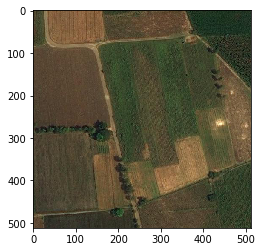

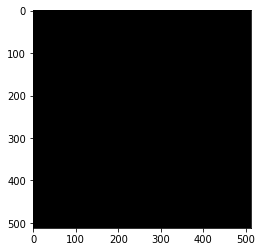

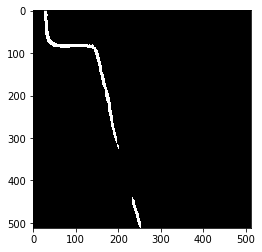

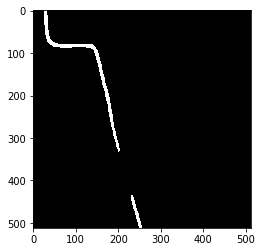

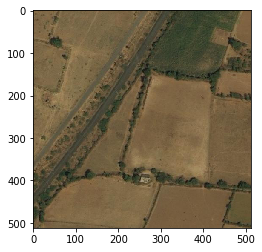

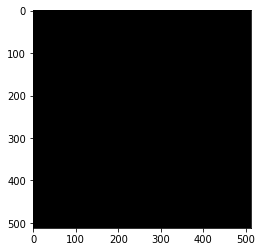

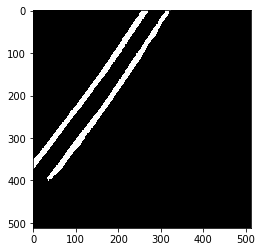

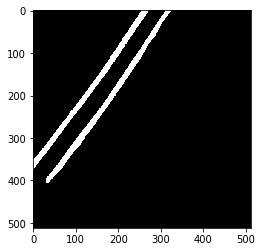

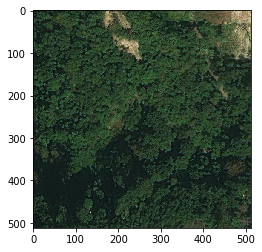

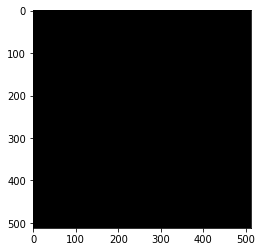

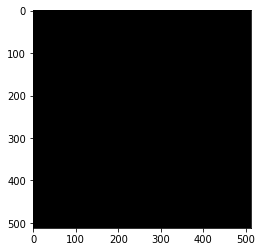

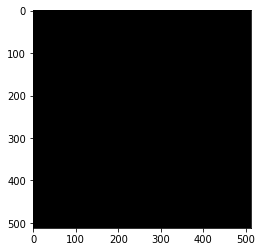

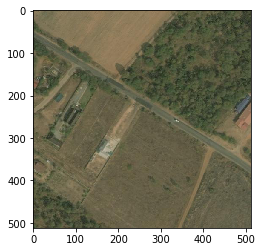

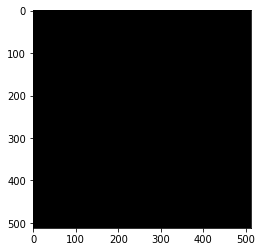

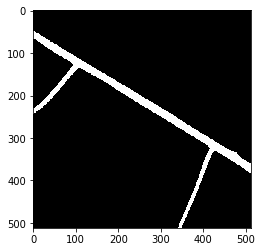

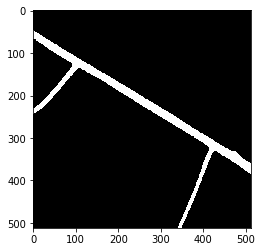

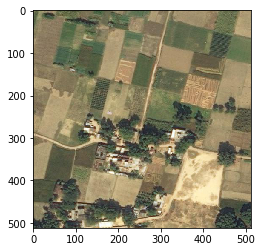

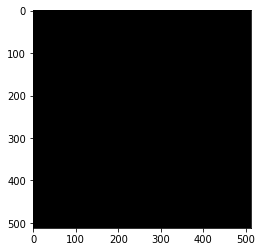

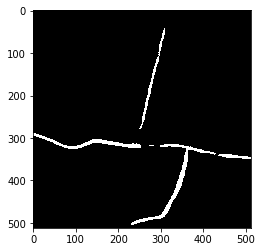

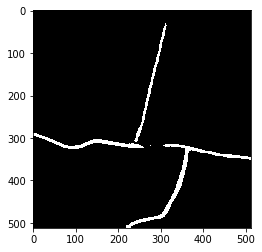

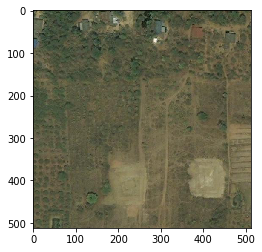

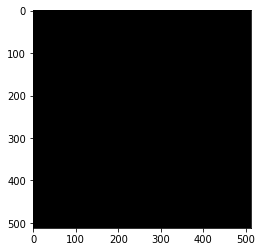

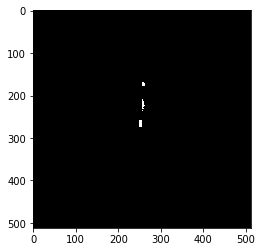

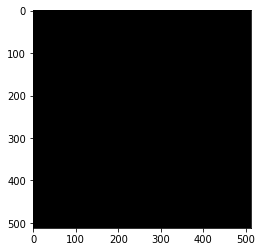

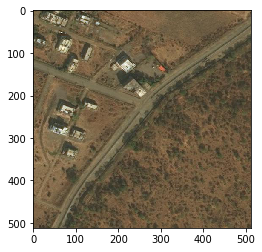

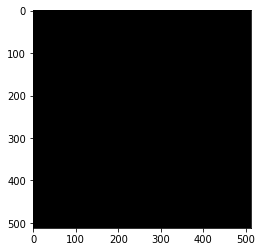

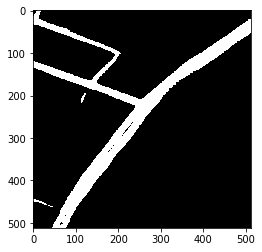

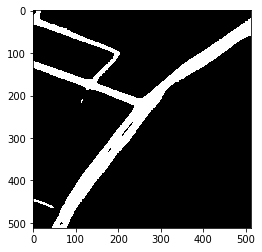

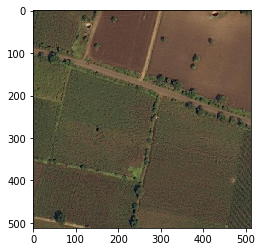

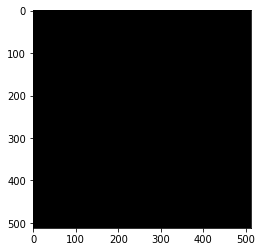

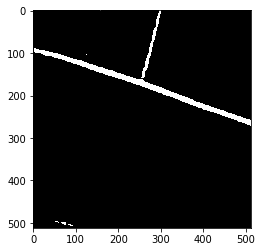

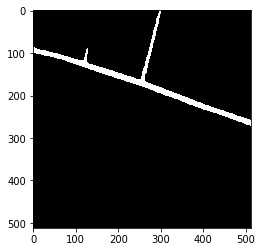

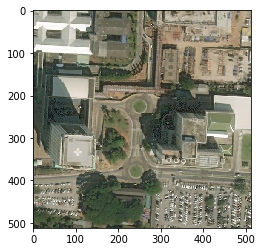

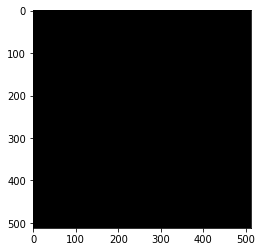

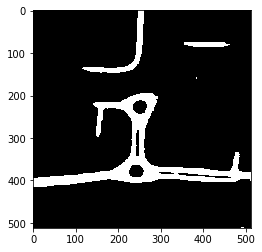

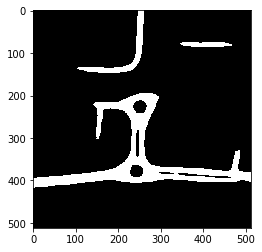

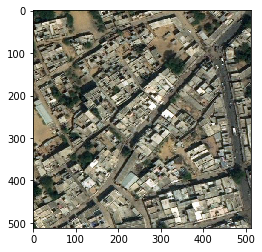

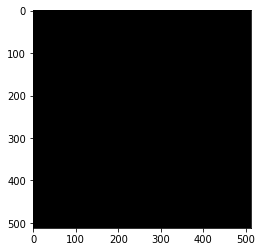

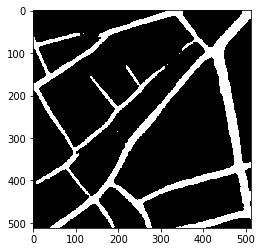

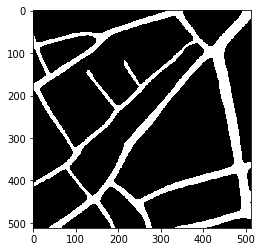

215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169
413.9165368080139


In [41]:
#create submission
tic = time.time()
create_submission("unet_pred_25.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)
